## Dependencies

In [3]:
rm(list = ls()) # clear memory
library(rpart) # decision tree
library(rpart.plot) # allows to plot decision tree
library(dummy) # dummy generation
library(ggplot2) # plot
library(ggfortify) # ggplot2 object interpreter
library(ggConvexHull) # used for colored areas on pca (bi)plot
library(GGally) # pairs plot
library(randomForest) # random forests
library(MLmetrics)
set.seed(314) # set seed for RNG

dummy 0.1.3

dummyNews()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall




In [4]:
ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # it may happen that a label is never predicted (missing from y_pred) but exists in y_true
    # in this case ConfusionDF will not have these lines and thus the simplified code crashes
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]))
   
    # workaround:
    # i don't want to change ConfusionDF since i don't know if the current behaviour is a feature or a bug.
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # short version, comment out due to bug or feature of Confusion_DF
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]))
   
    # workaround:
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred)) # possible problems if labels are missing from y_*
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

In [5]:
qualityAssessment = function(y_pred, y_true){
    print("Confusion Matrix")
    print(ConfusionMatrix(y_pred, y_true))
    print("----------------")
    print("Confusion DF")
    print(ConfusionDF(y_pred, y_true))
    print("----------------")
    print("Precision Micro")
    print(Precision_micro(y_true, y_pred))
    print("----------------")
    print("Recall Micro")
    print(Recall_micro(y_true, y_pred))
    print("----------------")
    print("F1 Score Micro")
    print(F1_Score_micro(y_true, y_pred))
}

- **INT**
  - `geo_level_1_id, geo_level_2_id, geo_level_3_id` geographic region of building, largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.
  - `count_floors_pre_eq` number of floors in the building before the earthquake.
  - `age` age of the building in years.
  - `area_percentage` normalized area of the building footprint.
  - `height_percentage` normalized height of the building footprint.
- **CATEGORICAL**
  - `land_surface_condition` surface condition of the land where the building was built. Possible values: n, o, t.
  - `foundation_type` type of foundation used while building. Possible values: h, i, r, u, w.
  - `roof_type` type of roof used while building. Possible values: n, q, x.
  - `ground_floor_type` type of the ground floor. Possible values: f, m, v, x, z.
  - `other_floor_type` type of constructions used in higher than the ground floors (except of roof). Possible values: j, q, s, x.
  - `position` position of the building. Possible values: j, o, s, t.
  - `plan_configuration` building plan configuration. Possible values: a, c, d, f, m, n, o, q, s, u.
  - `legal_ownership_status` legal ownership status of the land where building was built. Possible values: a, r, v, w.
- **BINARY**
  - `has_superstructure_adobe_mud` superstructure was made of Adobe/Mud.
  - `has_superstructure_mud_mortar_stone`superstructure was made of Mud Mortar - Stone.
  - `has_superstructure_stone_flag` superstructure was made of Stone.
  - `has_superstructure_cement_mortar_stone` superstructure was made of Cement Mortar - Stone.
  - `has_superstructure_mud_mortar_brick` superstructure was made of Mud Mortar - Brick.
  - `has_superstructure_cement_mortar_brick` superstructure was made of Cement Mortar - Brick.
  - `has_superstructure_timber` superstructure was made of Timber.
  - `has_superstructure_bamboo` superstructure was made of Bamboo.
  - `has_superstructure_rc_non_engineered` superstructure was made of non-engineered reinforced concrete.
  - `has_superstructure_rc_engineered` superstructure was made of engineered reinforced concrete.
  - `has_superstructure_other` superstructure was made of any other material.
  - `count_families` number of families that live in the building.
  - `has_secondary_use` building was used for any secondary purpose.
  - `has_secondary_use_agriculture` building was used for agricultural purposes.
  - `has_secondary_use_hotel` building was used as a hotel.
  - `has_secondary_use_rental` building was used for rental purposes.
  - `has_secondary_use_institution` building was used as a location of any institution.
  - `has_secondary_use_school` building was used as a school.
  - `has_secondary_use_industry` building was used for industrial purposes.
  - `has_secondary_use_health_post` building was used as a health post.
  - `has_secondary_use_gov_office` building was used fas a government office.
  - `has_secondary_use_use_police` building was used as a police station.
  - `has_secondary_use_other` building was secondarily used for other purposes.



# Task I

## Data pre-processing
- Conversion of strings to factors to include the categorical variables.
- Are there any NAs in the `train_values.csv` data set?
- Dummy variables generation from `dummy` package and add them to original dataset

In [6]:
data = read.csv("train_values.csv", stringsAsFactors=T)
trainLabels = read.csv("train_labels.csv")
testValues = read.csv("test_values.csv")

As we can see by summing the number of `NA` entries for each feature, there are no undefined entries in the dataset.

In [7]:
sum(colSums(is.na(data)))

[1] 0

Display the different categorical variables with their respective levels.
Here we generate the `dataDums` data frame, which contains all the associated levels to the original categorical variables. We ask `dummy` to return us integer variables, because by default it returns character variables. We don't have to do additional modifications on the variables names as the levels are encoded by just one letter.
Then we fetch the original categorical variables `varsToRemove`, we define `dataPP` as being the `data` df minus the columns that are factors merged together with the `dataDums` data frame we generated before.

In [8]:
print(categories(x=data, p="all"))

dataDums = dummy(data, int=TRUE, p="all")

varsToRemove = which(sapply(data[1,],class)=="factor")

dataPP = cbind(data[,-varsToRemove], dataDums)

$land_surface_condition
[1] "n" "o" "t"

$foundation_type
[1] "h" "i" "r" "u" "w"

$roof_type
[1] "n" "q" "x"

$ground_floor_type
[1] "f" "m" "v" "x" "z"

$other_floor_type
[1] "j" "q" "s" "x"

$position
[1] "j" "o" "s" "t"

$plan_configuration
 [1] "a" "c" "d" "f" "m" "n" "o" "q" "s" "u"

$legal_ownership_status
[1] "a" "r" "v" "w"



In [14]:
dataPP$damage_grade = trainLabels$damage_grade

In [15]:
pca = prcomp(dataPP,scale=TRUE) #pca on the clinical variables, discarding the two factor variables

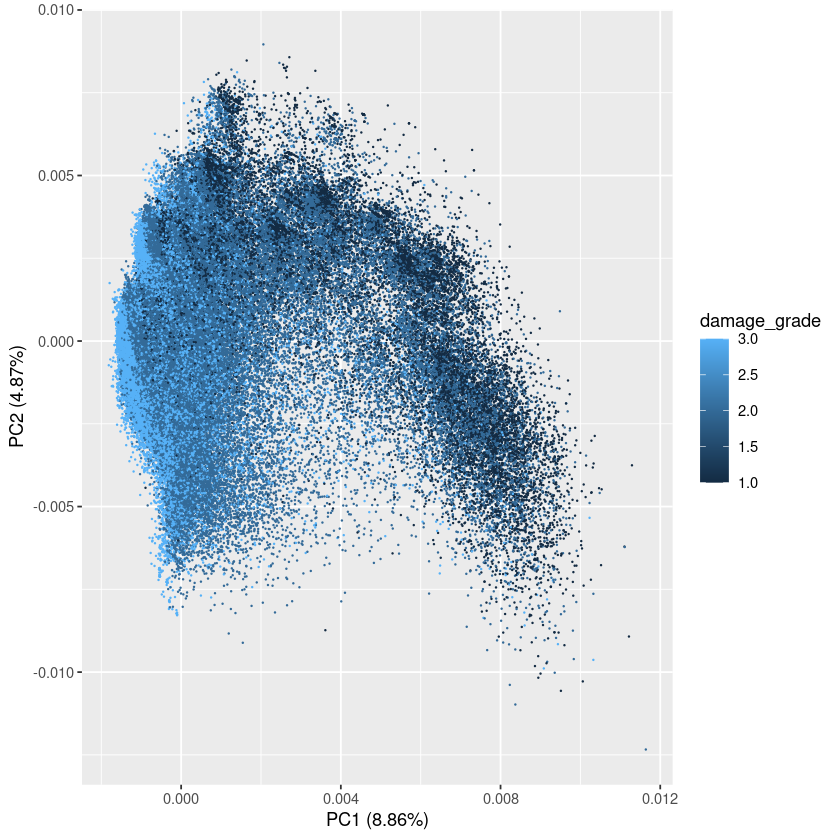

In [59]:
plotPca = function(pca, main, second){
     autoplot(pca, x = main, y = second, data = dataPP, colour = 'damage_grade', loadings = FALSE, loadings.colour = 'blue', loadings.label = FALSE, loadings.label.size = 3, size=0.05)
}
plotPca(pca, 1, 2)
# ggsave("test.png", dpi=600)

 [1] 8.861787e+00 4.871260e+00 3.448764e+00 3.065798e+00 2.928531e+00
 [6] 2.821359e+00 2.659487e+00 2.475517e+00 2.369689e+00 2.291399e+00
[11] 2.128647e+00 1.939873e+00 1.835556e+00 1.706689e+00 1.604662e+00
[16] 1.559717e+00 1.516839e+00 1.507966e+00 1.493604e+00 1.480128e+00
[21] 1.465823e+00 1.459338e+00 1.452272e+00 1.450186e+00 1.441538e+00
[26] 1.437019e+00 1.434812e+00 1.432844e+00 1.430454e+00 1.427894e+00
[31] 1.426330e+00 1.423200e+00 1.422953e+00 1.416646e+00 1.412577e+00
[36] 1.405255e+00 1.403161e+00 1.385239e+00 1.368981e+00 1.366500e+00
[41] 1.361736e+00 1.339585e+00 1.321860e+00 1.277976e+00 1.271363e+00
[46] 1.243290e+00 1.239522e+00 1.158483e+00 1.094303e+00 1.053648e+00
[51] 9.907851e-01 8.968684e-01 8.163132e-01 7.676296e-01 6.539235e-01
[56] 6.004694e-01 5.133708e-01 3.970811e-01 3.575765e-01 3.413992e-01
[61] 2.639181e-01 8.604191e-03 6.365546e-28 3.810224e-28 2.905871e-28
[66] 2.089243e-28 2.029348e-28 1.021618e-28 8.665328e-29 3.749977e-29
[1] 66.99945


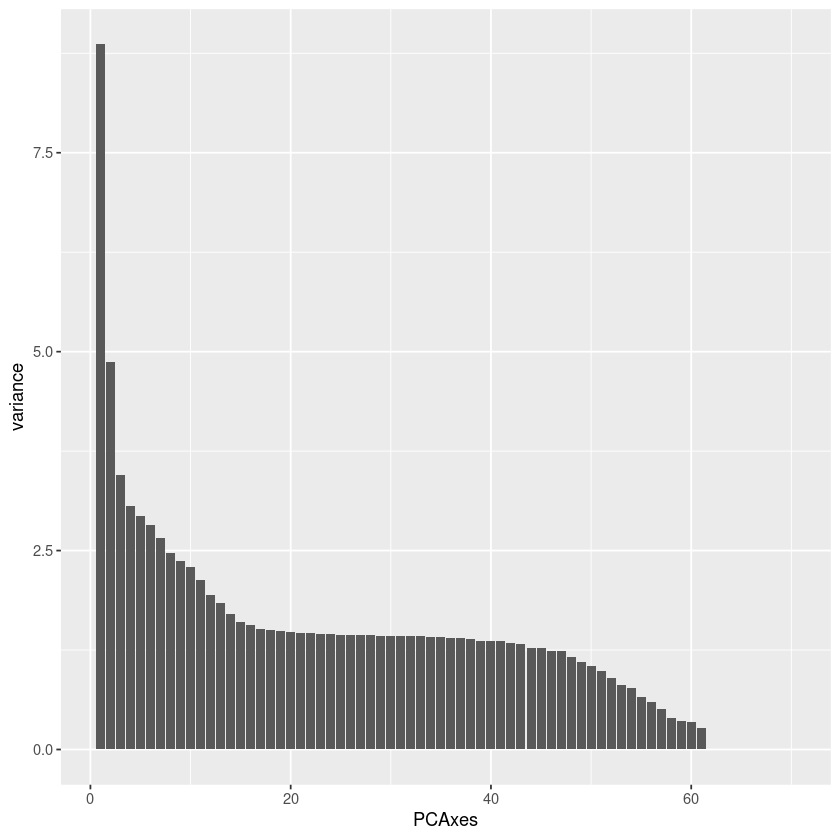

In [58]:
variance = (pca$sdev^2 / sum(pca$sdev^2))*100 # Compute a vector of each axis's variance
print(variance)
print(sum(variance[1:30])) 
PCAxes = c(1:70) # Build the five bars
d = data.frame(PCAxes, variance) # Associate each axis to its variance
ggplot(d, aes(PCAxes, variance)) + geom_col() # Plot variances

- Since we are dealing with 3 classes, we can instead use three binary classifiers (pairwise classification), so train a classifier for each pair of classes, compute the prediction of the three classifiers, if there is a class which receives the largest number of votes -> assign, otherwise if tie, break at random
- First classifier : 1 vs (2 and 3), second classifier : 2 vs (1 and 3), third classifier : 3 vs (1 and 2)
- In order to do that, we define three sets `firstSet`, `secondSet` and `thirdSet` which contains sets for which there are only two classifications possible.
- Then we generate a classifier for each set by using the practical method
- Then to generate the prediction list, for each item to predict, predict it using respectively the three models, generate a df where rows = sample and column = classifier1,...,classifier3, where the value is the most probable class. Then loop over the rows, for each rows determine the count of 1, 2, 3, and count for instance classification 23 as being +1 in 2 AND in 3

In [11]:
# RF : assessing the optimal number of features to consider per tree on the current dataset
set.seed(12345)
makeSet = function(d, toGroupFirst, toGroupSecond){
    
    dataPPtransition = d
    temp = toString(paste0(toGroupFirst, toGroupSecond))

    for(i in 1:nrow(dataPPtransition)){
        if(dataPPtransition[i,]$damage_grade == toGroupFirst | dataPPtransition[i,]$damage_grade == toGroupSecond){
            dataPPtransition[i,]$damage_grade = as.integer(temp)
        }
    }

    return(dataPPtransition)

}

In [12]:

counter = function(preds, number){
    return(sum(lengths(regmatches(preds, gregexpr(number, preds)))))
}

consensus = function(p1,p2,p3){

    preds = c(colnames(p1)[apply(p1,1,which.max)], colnames(p2)[apply(p2,1,which.max)], colnames(p3)[apply(p3,1,which.max)])

    countVectors = c(counter(preds, 1), counter(preds, 2), counter(preds, 3))

    return(which.max(countVectors))

}

decisionTree = function(input, model1, model2, model3){

    pred = c()

    for(i in 1:nrow(input)){

        p1 = predict(model1, input[i,])
        p2 = predict(model2, input[i,])
        p3 = predict(model3, input[i,])

        pred = c(pred, consensus(p1,p2,p3))
    }

    return(pred)

}
firstSet = makeSet(dataPP[20000:30000,], 2, 3) # 1 vs 2, 3
secondSet = makeSet(dataPP[20000:30000,], 1, 3) # 2 vs 1, 3
thirdSet = makeSet(dataPP[20000:30000,], 1, 2) # 3 vs 1, 2

firstModel = rpart(damage_grade ~ ., data=firstSet, method="class")
secondModel = rpart(damage_grade ~ ., data=secondSet, method="class")
thirdModel = rpart(damage_grade ~ ., data=thirdSet, method="class")

prediction = decisionTree(dataPP[1:10000,-70], firstModel, secondModel, thirdModel)

In [13]:
qualityAssessment(trainLabels[1:10000,]$damage_grade, prediction)

[1] "Confusion Matrix"
      y_pred
y_true    1    2    3
     1  186  134   47
     2  772 5196 2227
     3    8  348 1082
[1] "----------------"
[1] "Confusion DF"
  y_true y_pred Freq
1      1      1  186
2      2      1  772
3      3      1    8
4      1      2  134
5      2      2 5196
6      3      2  348
7      1      3   47
8      2      3 2227
9      3      3 1082
[1] "----------------"
[1] "Precision Micro"
[1] 0.6464
[1] "----------------"
[1] "Recall Micro"
[1] 0.6464
[1] "----------------"
[1] "F1 Score Micro"
[1] 0.6464
